## Inicialización del Notebook

### Instalar paquetes

In [1]:
# pip install pandas

In [2]:
# pip install matplotlib

In [3]:
# pip install wordcloud

In [4]:
# pip install nltk

In [5]:
# pip install xgboost

In [6]:
# pip install imblearn

### Imports

In [7]:
import pandas as pd
import numpy as np

import random

In [8]:
import string
import spacy
import nltk

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [9]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

### Variables globales

In [12]:
# URL del archivo de tweets en Github
github_url = 'https://raw.githubusercontent.com/Vialesoft/Vialesoft_Devlab/refs/heads/main/Cursos/DataScienceIII/Proyecto_Final/test2.csv'

## Lectura

In [13]:
# Cargo el archivo en un DataFrame de Pandas
df_tweets = pd.read_csv(github_url)
df_original = df_tweets # Dataframe original de reserva

df_tweets.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


## Análisis y limpieza del DataFrame

### Análisis primario

In [14]:
# Cantidad de filas
df_tweets.count()

textID              3534
text                3534
sentiment           3534
Time of Tweet       3534
Age of User         3534
Country             3534
Population -2020    3534
Land Area (Km�)     3534
Density (P/Km�)     3534
dtype: int64

In [15]:
# Información general del Dataframe
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km�)   3534 non-null   float64
 8   Density (P/Km�)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


In [16]:
# Revisamos valores nulos en las columnas
print(df_tweets.isnull().sum())

# Muchas filas completamente vacías (poco más de un tercio de las que si tienen información)

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km�)     1281
Density (P/Km�)     1281
dtype: int64


In [17]:
# Buscamos tweets duplicados
df_tweets.duplicated().sum()

# Las filas duplicadas son las vacías

np.int64(1280)

In [18]:
# Cantidad de países diferentes

df_tweets["Country"].nunique()
df_tweets.Country.nunique()

195

In [19]:
# Cantidad de sentimientos positivos, negativos y neutros
# Datos extraídos a mano
print("Positivos")
print(df_tweets.loc[df_tweets["sentiment"] == "positive"]["text"].count())
print("Negativos")
print(df_tweets.loc[df_tweets["sentiment"] == "negative"]["text"].count())
print("Neutrales")
print(df_tweets.loc[df_tweets["sentiment"] == "neutral"]["text"].count())

Positivos
1103
Negativos
1001
Neutrales
1430


In [20]:
# Agrupando por sentimiento identificado
df_GroupbySentiment = df_tweets.groupby("sentiment")

print("Cantidad de sentimientos")
print(df_GroupbySentiment.ngroups)

print("Cantidad de tweets clasificados por sentimiento")
print(df_GroupbySentiment.size())

Cantidad de sentimientos
3
Cantidad de tweets clasificados por sentimiento
sentiment
negative    1001
neutral     1430
positive    1103
dtype: int64


In [21]:
df_GroupbySentiment.count()

,textID,text,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
sentiment,,,,,,,,
negative,1001,1001,1001,1001,1001,1001,1001,1001
neutral,1430,1430,1430,1430,1430,1430,1430,1430
positive,1103,1103,1103,1103,1103,1103,1103,1103


In [22]:
def classifyByCountry(dataframe, sentiment):
    df_Country = df_GroupbySentiment.get_group(sentiment).groupby("Country").size().to_frame().reset_index()
    df_Country = df_Country.set_axis(["Country", "Quantity"], axis=1)
    df_Country = df_Country.sort_values("Quantity", ascending=False)

    return df_Country

In [23]:
# Clasificación por país y sentimientos

df_NegativeCountry = classifyByCountry(df_GroupbySentiment, "negative")
df_PositiveCountry = classifyByCountry(df_GroupbySentiment, "positive")
df_NeutralCountry = classifyByCountry(df_GroupbySentiment, "neutral")

print("Negativo")
print(df_NegativeCountry.head())
print("Positivo")
print(df_PositiveCountry.head())
print("Neutral")
print(df_NeutralCountry.head())

Negativo
       Country  Quantity
19      Bhutan        13
114   Mongolia        11
18       Benin        10
99   Lithuania        10
63     Georgia        10
Positivo
                             Country  Quantity
43                     C�te d'Ivoire        12
44  Democratic Republic of the Congo        10
25                      Burkina Faso        10
24                          Bulgaria         9
6                          Argentina         9
Neutral
                        Country  Quantity
62                       Gambia        13
34                        Chile        12
46                      Denmark        12
60                       France        12
56  Eswatini (fmr. "Swaziland")        12


#### Nube de palabras

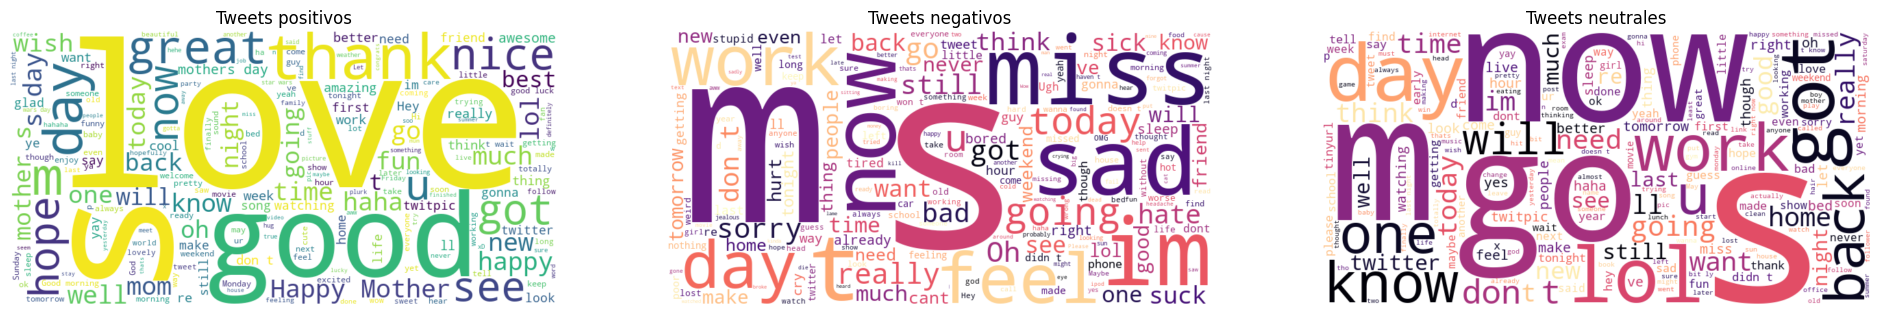

In [24]:
positive_twits = df_tweets[df_tweets['sentiment'] == 'positive']['text'].str.cat(sep=' ')
negative_twits = df_tweets[df_tweets['sentiment'] == 'negative']['text'].str.cat(sep=' ')
neutral_twits = df_tweets[df_tweets['sentiment'] == 'neutral']['text'].str.cat(sep=' ')

# Creando las wordclouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_twits)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(negative_twits)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(neutral_twits)

plt.figure(figsize=(24, 12))

plt.subplot(1,3,1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweets positivos', fontsize=12)

plt.subplot(1,3,2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweets negativos', fontsize=12)

plt.subplot(1,3,3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweets neutrales', fontsize=12)

plt.show()

### Limpieza del Dataframe

#### Eliminación de columnas innecesarias

Se eliminarán todas las columnas que no vamos a utilizar

In [25]:
df_tweets = df_tweets[["text", "sentiment", "Time of Tweet", "Country"]]

df_tweets.head()

,text,sentiment,Time of Tweet,Country
0,Last session of the day http://twitpic.com/67ezh,neutral,morning,Afghanistan
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria
3,happy bday!,positive,morning,Andorra
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola


#### Limpieza de valores nulos y duplicados

In [26]:
# Limpiamos valores nulos (y duplicados, al ser los duplicados solamente los nulos)
df_tweets = df_tweets.dropna()

In [27]:
# Chequeamos que no queden ni duplicados ni nulos
print (df_tweets.duplicated().sum())
print (df_tweets.isnull().sum())

0
text             0
sentiment        0
Time of Tweet    0
Country          0
dtype: int64


## Preprocesamiento

- 1: Convertir todo a minúsculas
- 2: Remover caracteres especiales *
- 3: Remover stopwords
- 4: Stemming y lemantización

### Eliminar sentimientos neutros

A modo de prueba, se intentará clasificar solo en negativos y positivos

In [28]:
df_tweets = df_tweets[df_tweets["sentiment"] != "neutral"]

df_tweets.head()

,text,sentiment,Time of Tweet,Country
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria
3,happy bday!,positive,morning,Andorra
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola
5,that`s great!! weee!! visitors!,positive,night,Antigua and Barbuda


### Convertir todo a minúsculas

Se decidió crear una nueva columna de tuits convertidos a minúsculas

In [29]:
df_tweets["text_lower"] = df_tweets.text.apply(lambda x: x.lower())
df_tweets.head()

,text,sentiment,Time of Tweet,Country,text_lower
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania,shanghai is also really exciting (precisely -...
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria,"recession hit veronique branquinho, she has to..."
3,happy bday!,positive,morning,Andorra,happy bday!
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola,http://twitpic.com/4w75p - i like it!!
5,that`s great!! weee!! visitors!,positive,night,Antigua and Barbuda,that`s great!! weee!! visitors!


In [30]:
# Analizar tokens
token_lists = [word_tokenize(each) for each in df_tweets["text"]]
tokens = [item for sublist in token_lists for item in sublist]
cant_tokens = len(set(tokens))
print("Tokens normales: ", cant_tokens)

token_lists_lower = [word_tokenize(each) for each in df_tweets["text_lower"]]
tokensLower = [item for sublist in token_lists_lower for item in sublist]
cant_tokensLower = len(set(tokensLower))
print("Tokens nuevos en minúsculas: ", cant_tokensLower)

print("Reducción en porcentaje: ", (1 - (cant_tokensLower / cant_tokens)) * 100)

# Se reduce la cantidad de tokens en casi un 15%

Tokens normales:  6166
Tokens nuevos en minúsculas:  5289
Reducción en porcentaje:  14.223159260460594


### Remover caracteres especiales*

La eliminación de caracteres especiales en este contexto no parece la mejor idea. En un tuit, las personas comparten links, enfatizan emociones a través de signos de exclamación e interrogación, e incluso mediante el uso de numerales al citar hashtags
Por este motivo, se decidió crear una nueva columna removiendo estos caracteres y, luego, generar un set de modelos con cada una de las columnas de texto, a fin de evaluar la precisión de cada uno cuando se remueven (o no) los caracteres especiales

In [31]:
def preprocess(text, special_words = False):
    # Tokenización
    words = nltk.word_tokenize(text)

    if(special_words):
        # Caracteres especiales
        words = [word for word in words if word not in string.punctuation]

    # Stop-Words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Volvemos a juntar y retornamos el texto pre procesado
    return ' '.join(words)

In [32]:
list_tweets = df_tweets["text_lower"].tolist()

In [33]:
list_tweets = [preprocess(tuit) for tuit in list_tweets]

In [34]:
df_tweets["text_cleaned"] = list_tweets

df_tweets.head()

,text,sentiment,Time of Tweet,Country,text_lower,text_cleaned
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania,shanghai is also really exciting (precisely -...,shanghai also really exciting ( precisely -- s...
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria,"recession hit veronique branquinho, she has to...","recession hit veronique branquinho , quit comp..."
3,happy bday!,positive,morning,Andorra,happy bday!,happy bday !
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola,http://twitpic.com/4w75p - i like it!!,http : //twitpic.com/4w75p - like ! !
5,that`s great!! weee!! visitors!,positive,night,Antigua and Barbuda,that`s great!! weee!! visitors!,` great ! ! weee ! ! visitor !


### Palabras más frecuentes

Como parte del análisis, obtenemos las palabras más frecuentes utilizadas por los twitteros

In [35]:
all_words = [word for sublist in [tweet.split() for tweet in list_tweets] for word in sublist]

# Distribución de frecuencia
fdist = Counter(all_words)

# Las 10 palabras más repetidas
top_10_words = fdist.most_common(10)

print("Las 10 palabras más repetidas:\n", top_10_words)

Las 10 palabras más repetidas:
 [('!', 1340), ('.', 1139), ('`', 895), (',', 659), ('*', 394), ('...', 289), ('?', 233), ('day', 192), ('good', 171), ('..', 151)]


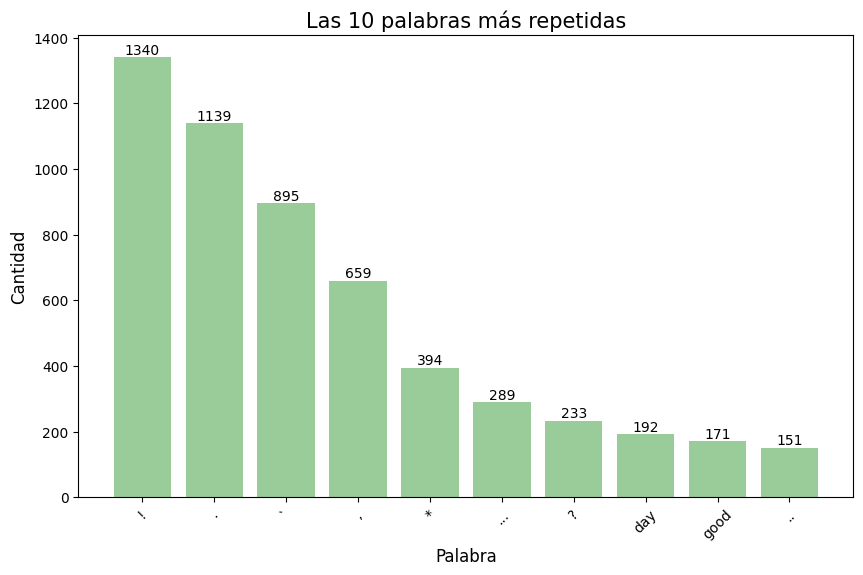

In [36]:
words, frequencies = zip(*top_10_words)

plt.figure(figsize=(10, 6))
bars = plt.bar(words, frequencies, color='Green',alpha=0.4)
plt.xlabel('Palabra', fontsize=12)

plt.xticks(fontsize=10)
plt.ylabel('Cantidad', fontsize=12)

plt.yticks(fontsize=10)
plt.title('Las 10 palabras más repetidas', fontsize=15)
plt.xticks(rotation=45)

for bar, frequency in zip(bars, frequencies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, frequency, ha='center', va='bottom', fontsize=10)

plt.show()

## DeepLearning

### Separación en datos de Train y Test

Primero se vectorizarán los textos y se codificarán los sentimientos
Se generarán tres sets de prueba distintos

- El texto común
- El texto "limpio"
- El texto en minúsculas pero sin modificaciones

Esto lo haremos para comparar cuál de los tres modelos resulta más preciso a la hora de predecir el sentimiento de la frase


In [37]:
df_tweets.head()

,text,sentiment,Time of Tweet,Country,text_lower,text_cleaned
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania,shanghai is also really exciting (precisely -...,shanghai also really exciting ( precisely -- s...
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria,"recession hit veronique branquinho, she has to...","recession hit veronique branquinho , quit comp..."
3,happy bday!,positive,morning,Andorra,happy bday!,happy bday !
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola,http://twitpic.com/4w75p - i like it!!,http : //twitpic.com/4w75p - like ! !
5,that`s great!! weee!! visitors!,positive,night,Antigua and Barbuda,that`s great!! weee!! visitors!,` great ! ! weee ! ! visitor !


In [38]:
list_tweets = df_tweets["text"].tolist()
list_tweets_lower = df_tweets["text_lower"].tolist()
list_tweets_cleaned = df_tweets["text_cleaned"].tolist()

In [39]:
# Vectorización TF-IDF
vectorizer = TfidfVectorizer()
X_tweets = vectorizer.fit_transform(list_tweets)
X_tweets_lower = vectorizer.fit_transform(list_tweets_lower)
X_tweets_cleaned = vectorizer.fit_transform(list_tweets_cleaned)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_tweets['sentiment'])

### Modelado

Primero separaremos las X en conjuntos de train y test, para cada conjunto

En esta primera instancia, el conjunto de test será de un 30%

In [40]:
# Separo en conjuntos de train y test

X_train_tweets, X_test_tweets, y_train_tweets, y_test_tweets = train_test_split(X_tweets, y, test_size=0.3, random_state=42)
X_train_tweets_lower, X_test_tweets_lower, y_train_tweets_lower, y_test_tweets_lower = train_test_split(X_tweets_lower, y, test_size=0.3, random_state=42)
X_train_tweets_cleaned, X_test_tweets_cleaned, y_train_tweets_cleaned, y_test_tweets_cleaned = train_test_split(X_tweets_cleaned, y, test_size=0.3, random_state=42)

list_Xs = [
    (X_train_tweets, X_test_tweets, y_train_tweets, y_test_tweets, "Tweets originales"),
    (X_train_tweets_lower, X_test_tweets_lower, y_train_tweets_lower, y_test_tweets_lower, "Tweets en minúscula"),
    (X_train_tweets_cleaned, X_test_tweets_cleaned, y_train_tweets_cleaned, y_test_tweets_cleaned, "Tweets limpios")
]

In [41]:
# Los modelos con sus parámetros
models = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1],
            'penalty': ['l1', 'l2']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20]
        }
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.1, 0.01],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200]
        }
    }
}

# Los modelos con sus parámetros
models = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1],
            'penalty': ['l2']
        }
    }
}

In [42]:
# Definimos una función para evaluar cada modelo
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred) # , average='weighted' weighted, micro, macro, None
    recall = recall_score(y_val, y_pred) # , average='weighted'
    f1 = f1_score(y_val, y_pred) #, average='weighted'
    confusion = confusion_matrix(y_val, y_pred)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'confusion': confusion}

In [43]:
# Entrenamos y evaluamos los modelos
model_performance = {}
for (train, test, yTrain, yTest, title) in list_Xs:
    for model_name, config in models.items():
        clf = GridSearchCV(config['model'], config['params'], cv=5) #scoring='f1_weighted'
        clf.fit(train, yTrain)
        best_model = clf.best_estimator_
    
        metrics = evaluate_model(best_model, train, yTrain, test, yTest)
        model_performance[model_name] = metrics
        print(f"{model_name} / {title}: Accuracy={metrics['accuracy']}, Precision={metrics['precision']}, Recall={metrics['recall']}, F1={metrics['f1']}")

C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\

LogisticRegression / Tweets originales: Accuracy=0.8006329113924051, Precision=0.8228228228228228, Recall=0.8035190615835777, F1=0.8130563798219584
RandomForestClassifier / Tweets originales: Accuracy=0.7958860759493671, Precision=0.8486842105263158, Recall=0.7565982404692082, F1=0.8
SVC / Tweets originales: Accuracy=0.8022151898734177, Precision=0.8333333333333334, Recall=0.7917888563049853, F1=0.8120300751879699
MultinomialNB / Tweets originales: Accuracy=0.8212025316455697, Precision=0.8257142857142857, Recall=0.8475073313782991, F1=0.8364688856729378
KNeighborsClassifier / Tweets originales: Accuracy=0.7610759493670886, Precision=0.7698863636363636, Recall=0.7947214076246334, F1=0.7821067821067821
XGBClassifier / Tweets originales: Accuracy=0.7800632911392406, Precision=0.8768656716417911, Recall=0.6891495601173021, F1=0.7717569786535303
LogisticRegression / Tweets en minúscula: Accuracy=0.8006329113924051, Precision=0.8228228228228228, Recall=0.8035190615835777, F1=0.8130563798219

C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\

RandomForestClassifier / Tweets en minúscula: Accuracy=0.7879746835443038, Precision=0.8484848484848485, Recall=0.7390029325513197, F1=0.7899686520376176
SVC / Tweets en minúscula: Accuracy=0.8022151898734177, Precision=0.8333333333333334, Recall=0.7917888563049853, F1=0.8120300751879699
MultinomialNB / Tweets en minúscula: Accuracy=0.8212025316455697, Precision=0.8257142857142857, Recall=0.8475073313782991, F1=0.8364688856729378
KNeighborsClassifier / Tweets en minúscula: Accuracy=0.7610759493670886, Precision=0.7698863636363636, Recall=0.7947214076246334, F1=0.7821067821067821
XGBClassifier / Tweets en minúscula: Accuracy=0.7800632911392406, Precision=0.8768656716417911, Recall=0.6891495601173021, F1=0.7717569786535303
LogisticRegression / Tweets limpios: Accuracy=0.8117088607594937, Precision=0.8512658227848101, Recall=0.7888563049853372, F1=0.8188736681887366


C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\envs\DataScience\Lib\site-packages\

RandomForestClassifier / Tweets limpios: Accuracy=0.819620253164557, Precision=0.9157509157509157, Recall=0.7331378299120235, F1=0.8143322475570033
SVC / Tweets limpios: Accuracy=0.8164556962025317, Precision=0.8526645768025078, Recall=0.7976539589442815, F1=0.8242424242424242
MultinomialNB / Tweets limpios: Accuracy=0.8212025316455697, Precision=0.8166666666666667, Recall=0.8621700879765396, F1=0.8388017118402282
KNeighborsClassifier / Tweets limpios: Accuracy=0.759493670886076, Precision=0.8098360655737705, Recall=0.7243401759530792, F1=0.7647058823529411
XGBClassifier / Tweets limpios: Accuracy=0.7895569620253164, Precision=0.9126984126984127, Recall=0.6744868035190615, F1=0.7757166947723441


Se hicieron las pruebas con los tres conjuntos de tuits, consiguiendo la misma precisión con los tres sets de datos
Esto puede deberse a que, para este caso de evaluación de tuits, las transformaciones hechas a los textos realmente no afectan los resultados finales, o bien que por la cantidad de filas, la afectación es mínima

In [44]:
# Select the best model based on validation performance
best_model_name = max(model_performance, key=lambda k: model_performance[k]['f1'])
best_model = models[best_model_name]['model']

best_model

MultinomialNB()

In [45]:
print(best_model_name)

MultinomialNB


In [53]:
best_model.fit(X_train_tweets_cleaned, y_train_tweets_cleaned)
y_pred_tweets_cleaned = best_model.predict(X_test_tweets_cleaned)

### Evaluación del mejor modelo (Multinomial NB) con el set de pruebas

In [55]:
accuracy = accuracy_score(y_test_tweets_cleaned, y_pred_tweets_cleaned)
precision = precision_score(y_test_tweets_cleaned, y_pred_tweets_cleaned)
recall = recall_score(y_test_tweets_cleaned, y_pred_tweets_cleaned)
f1 = f1_score(y_test_tweets_cleaned, y_pred_tweets_cleaned)
confusion = confusion_matrix(y_test_tweets_cleaned, y_pred_tweets_cleaned)

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1}")
print(f"Confusion Matrix:\n{confusion}")

Best Model: MultinomialNB
Test Accuracy: 0.8212025316455697
Test Precision: 0.8166666666666667
Test Recall: 0.8621700879765396
Test F1-Score: 0.8388017118402282
Confusion Matrix:
[[225  66]
 [ 47 294]]


## Prueba con ejemplos inventados

In [48]:
sample_tweets = ["I'm really happy, my son is five years old!.",
                  "I hate absolutely how the world is going",
                  "I think politics are being bad",
                  "I have gone to the best restaurant ever!!",
                  "I'm just OK",
                  "I think I will come back to Ushuaia next year! #Penguins",
                  "Bus tickets are so expensive! Goverment is really bad!",
                  "I have had the worst dining experience ever. The food was cold and the waiter was rude."]

In [49]:
sample_tweets_preprocessed = [preprocess(tweet) for tweet in sample_tweets]
sample_tweets_vectorized = vectorizer.transform(sample_tweets_preprocessed)
sample_tweets_predictions = best_model.predict(sample_tweets_vectorized)

In [56]:
predicted_labels_formatted = [f"Positive ({prediction})" if prediction == 1 else f"Negative ({prediction})" for prediction in sample_tweets_predictions]

results = dict(zip(sample_tweets, predicted_labels_formatted))

for tweet, prediction in results.items():
    print(f"Tweet: {tweet}\nPrediction: {prediction}\n")

Tweet: I'm really happy, my son is five years old!.
Prediction: Positive (1)

Tweet: I hate absolutely how the world is going
Prediction: Negative (0)

Tweet: I think politics are being bad
Prediction: Negative (0)

Tweet: I have gone to the best restaurant ever!!
Prediction: Positive (1)

Tweet: I'm just OK
Prediction: Positive (1)

Tweet: I think I will come back to Ushuaia next year! #Penguins
Prediction: Positive (1)

Tweet: Bus tickets are so expensive! Goverment is really bad!
Prediction: Negative (0)

Tweet: I have had the worst dining experience ever. The food was cold and the waiter was rude.
Prediction: Negative (0)



La precisión del modelo parece buena, para los ejemplos inventados

Existe sin embargo cierto sesgo hacia el lado positivo (como en el caso de I'm just OK) que debería haberse catalogado quizá como neutral, de existir esta tercera categoría

En las siguientes pruebas, tomaremos 100 tweets random del set y probaremos el modelo con ellos

In [51]:
def get_random_tweets(list_tweets, num_tweets=10):
  random_indices = random.sample(range(len(list_tweets)), num_tweets)
  random_tweets = [list_tweets[i] for i in random_indices]
  return random_tweets

In [58]:
random_tweets = get_random_tweets(list_tweets, 100)

random_tweets_preprocessed = [preprocess(tweet) for tweet in random_tweets]
random_tweets_vectorized = vectorizer.transform(random_tweets_preprocessed)
random_predictions = best_model.predict(random_tweets_vectorized)

In [59]:
random_predicted_labels_formatted = [f"Positive ({prediction})" if prediction == 1 else f"Negative ({prediction})" for prediction in random_predictions]
random_results = dict(zip(random_tweets, random_predicted_labels_formatted))

for tweet, prediction in random_results.items():
    print(f"Tuit: {tweet}\nPrediction: {prediction}\n")

Tuit: Woo! Two days till awesome gig, one day till Uni is finished for 12 days  #gigs #3yp
Prediction: Positive (1)

Tuit: Wow what a storm we just had!!! Now no power
Prediction: Positive (1)

Tuit: study all day.  just finished my care plan.  hungry as hell!  ima go treat myself with a burrito, for a good days work
Prediction: Positive (1)

Tuit: playing bejewled on facebook.. **** it i want a higherscore!
Prediction: Negative (0)

Tuit: _queen like it
Prediction: Negative (0)

Tuit:  so sorry to hear that
Prediction: Negative (0)

Tuit: in school w. linda doing nothing  ;i miss you
Prediction: Negative (0)

Tuit:  Yes, have to be right for church
Prediction: Positive (1)

Tuit:  I had to look at it 3 times before it sunk in, totally shocked by it  tbh.
Prediction: Positive (1)

Tuit: happy mothers day mommy  i love you so much, dono what id do without you ??
Prediction: Positive (1)

Tuit: Is bummed out...i don`t have even one testimonial on Flickr.
Prediction: Negative (0)

Tuit:  

La precisión de los tuits elegidos al azar parece buena en términos generales. Sin embargo, tiene algunos errores, propios de un modelo con una precisión de apenas sobre 80%